# Exploratory Data Analysis: YAMNet Embeddings

This notebook analyzes the high-dimensional feature space produced by Google's **YAMNet** model. Unlike hand-crafted features (RMS, ZCR, Tempo), YAMNet embeddings are 1024-dimensional vectors extracted from a deep convolutional neural network trained on millions of audio clips.

We will visualize these embeddings using dimension reduction techniques to see how well they naturally cluster by mood.

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tqdm import tqdm

sns.set(style="whitegrid")
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

c:\Users\andiz\anaconda3\envs\roodio-env\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version



TensorFlow version: 2.20.0
GPU Available: []


In [2]:
# Path Configuration
DATA_PATHS = ["../../data/raw", "../../data/raw2"]
MOODS = ["angry", "happy", "relaxed", "sad"]
TARGET_SR = 16000 # YAMNet expects 16kHz

### 1. Load YAMNet Model
We load the pre-trained YAMNet model from TensorFlow Hub.

In [3]:
print("Loading YAMNet from TF Hub...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
print("Model loaded successfully.")

Loading YAMNet from TF Hub...



Model loaded successfully.


### 2. Feature Extraction
We iterate through all songs, load them at 16kHz, normalize them, and extract the global embedding (mean of all frame-wise embeddings).

In [4]:
def extract_embedding(file_path):
    try:
        # Load audio at 16kHz as required by YAMNet
        wav, _ = librosa.load(file_path, sr=TARGET_SR)
        
        # Basic normalization
        max_val = np.max(np.abs(wav))
        if max_val > 0: 
            wav = wav / max_val
        else: 
            return None

        # Run model
        scores, embeddings, spectrogram = yamnet_model(wav)
        
        # Global average pooling of embeddings
        global_embedding = tf.reduce_mean(embeddings, axis=0).numpy()
        return global_embedding
    
    except Exception as e:
        print(f"\nError processing {file_path}: {e}")
        return None

data = []
for mood in MOODS:
    print(f"Processing {mood} songs...")
    for dp in DATA_PATHS:
        mood_path = os.path.join(dp, mood)
        if not os.path.exists(mood_path): continue
        
        files = [f for f in os.listdir(mood_path) if f.lower().endswith(('.wav', '.mp3'))]
        for file in tqdm(files, desc=f"  {os.path.basename(dp)}"):
            file_path = os.path.join(mood_path, file)
            emb = extract_embedding(file_path)
            if emb is not None:
                data.append({
                    "filename": file,
                    "mood": mood,
                    "embedding": emb
                })

df = pd.DataFrame(data)
embeddings_matrix = np.stack(df['embedding'].values)
print(f"\nTotal songs processed: {len(df)}")
print(f"Embeddings matrix shape: {embeddings_matrix.shape}")

Processing angry songs...


  raw2: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Processing happy songs...


  raw2: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Processing relaxed songs...


  raw2: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Processing sad songs...


  raw2: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Total songs processed: 200
Embeddings matrix shape: (200, 1024)


### 3. Dimension Reduction (PCA + t-SNE)
Since the embeddings are 1024-dimensional, we first use PCA to reduce the search space to 50 dimensions (capturing major variance) and then t-SNE to map it to 2D for visualization.

In [6]:
print("Applying PCA (1024D -> 50D)...")
pca = PCA(n_components=50, random_state=42)
pca_features = pca.fit_transform(embeddings_matrix)

print("Applying t-SNE (50D -> 2D)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(pca_features)

df['tsne-1'] = tsne_results[:,0]
df['tsne-2'] = tsne_results[:,1]
# Calculate Silhouette Scores
sil_score_full = silhouette_score(embeddings_matrix, df['mood'])
sil_score_tsne = silhouette_score(tsne_results, df['mood'])

print(f"Silhouette Score (1024D): {sil_score_full:.4f}")
print(f"Silhouette Score (t-SNE 2D): {sil_score_tsne:.4f}")


Applying PCA (1024D -> 50D)...
Applying t-SNE (50D -> 2D)...


### 5. Quantitative Analysis: Silhouette Score
The **Silhouette Score** measures how similar an object is to its own cluster compared to other clusters. 
- A score near **+1** indicates that the sample is far away from the neighboring clusters.
- A score of **0** indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
- Negative values indicate that those samples might have been assigned to the wrong cluster.

We calculate it for both the original 1024D space and the reduced 2D t-SNE space.

### 4. Visualization
We plot the t-SNE results to see how the moods are distributed.

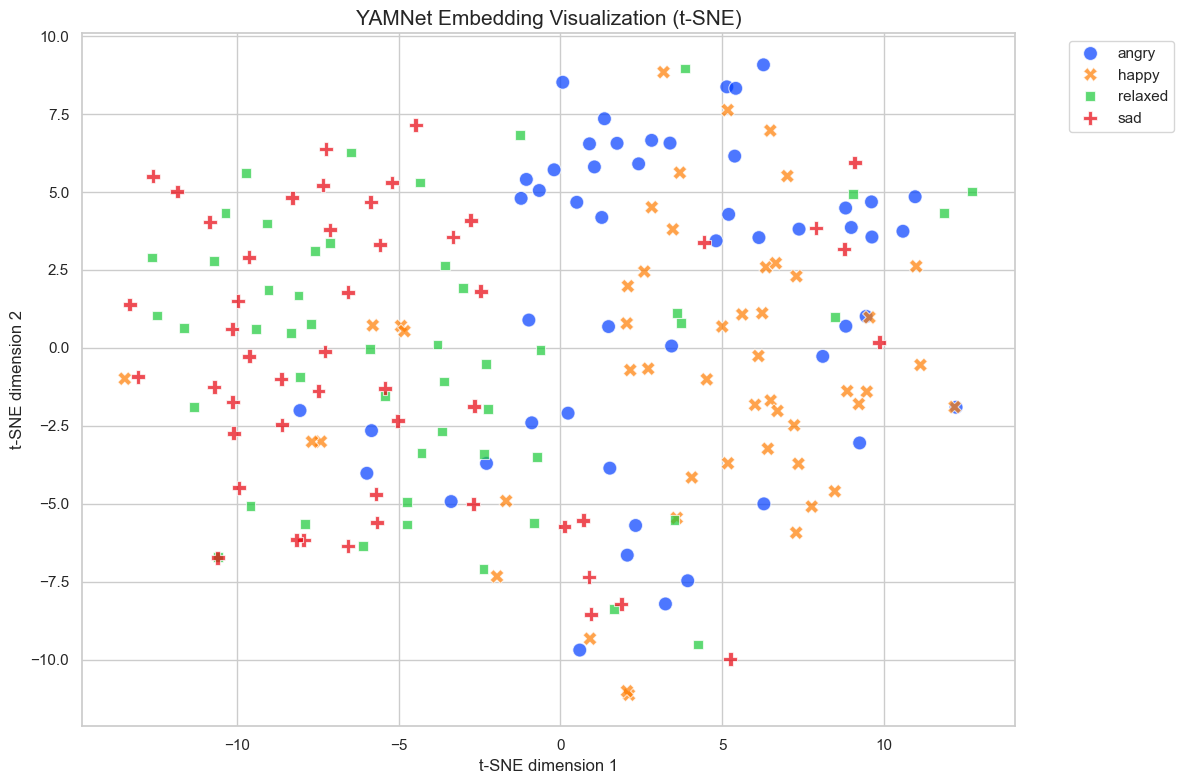

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="mood",
    style="mood",
    palette="bright",
    data=df,
    legend="full",
    alpha=0.7,
    s=100
)
plt.title("YAMNet Embedding Visualization (t-SNE)", fontsize=15)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Analysis & Interpretation**

**Deep Feature Power**:
Unlike the hand-crafted features in Part 1-3, YAMNet captures complex acoustic patterns (timbre, texture, specific sound events) that are often missed by simple RMS or ZCR. 

**Cluster Observation**:
- If points of the same color are tightly grouped, it means the deep features are excellent at distinguishing that mood.
- Overlaps between `sad` and `relaxed` are common because they share similar acoustic characteristics (low arousal).
- `angry` and `happy` often shift toward different regions but might overlap if they share high energy.

**Conclusion for ML**:
If we see clear clusters here, a simple classifier (like SVM or a small Dense NN) will perform very well on these embeddings. This visualization confirms why your Hybrid Model (which uses these embeddings) achieves high accuracy.